In [1]:
import os
import pickle
from glob import glob
from subprocess import run

from tqdm.notebook import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
CHECKPOINT = os.environ.get('NOTEBOOK_CHECKPOINT_FILENAME', 'runs/for_plot/train_step_1.pkl')
HEATMAP_SIZE = int(os.environ.get('NOTEBOOK_HEATMAP_SIZE', '32'))

In [3]:
print("Looking for root dir")
while not glob('.git/'):
    print("No git repo in", os.getcwd())
    os.chdir('..')
print("Found git repo in", os.getcwd())

Looking for root dir
No git repo in /home/kr/outrl/scripts
Found git repo in /home/kr/outrl


In [4]:
checkpoint_abspath = os.path.abspath(CHECKPOINT)
print(checkpoint_abspath)
with open(checkpoint_abspath, 'rb') as f:
    data = pickle.load(f)

/home/kr/outrl/runs/for_plot/train_step_1.pkl


In [5]:
print(data.keys())

dict_keys(['actor', 'vf', 'reward_normalizer', 'actor_optimizer', 'vf_optimizer', 'vf_lr_scheduler', 'actor_lr_scheduler', 'kl_coef_opt', 'awr_temperature_opt', 'kl_coef', 'awr_temperature', 'training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'cfg', 'observation_latent_size', '_replay_buffer', '_next_episode_number', '_dtype', 'total_env_steps', 'train_steps_so_far', 'last_training_stats', 'last_eval_stats', 'primary_performance', 'best_checkpoint_primary_performance', 'train_steps_so_far_at_last_checkpoint', 'total_actor_grad_steps'])


In [6]:
def obs_to_coord(obs):
    assert len(obs.shape) == 2
    assert obs.shape[0] == 3
    theta = np.arctan2(raw_obs[:, 0], raw_obs[:, 1])
    theta_norm = (HEATMAP_SIZE - 1) * theta / (2 * np.pi)
    ang_vel_norm = (HEATMAP_SIZE - 1) * (raw_obs[:, 2] + 8.0) / 16.0
    return theta_norm, ang_vel_norm

obs_heatmap = np.zeros((HEATMAP_SIZE, HEATMAP_SIZE))
all_obs = np.stack([ep_data.episode['observations'] for ep_data in data['_replay_buffer']]).transpose(2, 0, 1)

theta = np.arctan2(all_obs[0], all_obs[1])
theta_idx = np.floor((HEATMAP_SIZE - 1) * theta / (2 * np.pi)).astype(int).flatten()
ang_vel = all_obs[2]
ang_vel_idx = np.floor((HEATMAP_SIZE - 1) * (ang_vel + 8.0) / 16.0).astype(int).flatten()
for i, x in enumerate(theta_idx):
    obs_heatmap[x,ang_vel_idx[i]] += 1

In [7]:
import outrl
from outrl.gym_utils import GymBoxActor
import examples.gym_example as gym_example

cfg = gym_example.GymConfig.from_dict(data['cfg'])
actor = GymBoxActor(
    obs_size=3,
    action_size=1,
    hidden_sizes=cfg.encoder_hidden_sizes, 
    pi_hidden_sizes=cfg.pi_hidden_sizes, 
    init_std=cfg.init_std, 
    min_std=cfg.min_std)

trainer = outrl.rl.Trainer(cfg, actor)
trainer.load_state_dict(data)

In [8]:
train_inputs = trainer.preprocess()

In [9]:
vf_vals = np.stack([train_input.vf_returns for train_input in train_inputs])
vf_vals.shape

(200, 100)

In [10]:
advantages = np.stack([train_input.advantages for train_input in train_inputs])
advantages.shape

(200, 100)

In [11]:
d_ang_vel = ang_vel[:, 1:] - ang_vel[:, -1:]
d_theta = theta[:, 1:] - theta[:, -1:]
d_ang_vel.shape

(200, 100)

In [12]:
all_actions = np.stack([ep_data.episode['actions']
                        for ep_data in data['_replay_buffer']]).transpose(2, 0, 1)

In [13]:
all_actions

array([[[ 0.43302184, -0.68650925,  0.4932501 , ...,  0.56588614,
          0.22471409, -0.43225345],
        [-0.11117496, -0.725191  ,  0.03396646, ..., -0.6529731 ,
          0.99853796,  0.5484882 ],
        [-0.02038532, -1.0888318 , -0.6388675 , ...,  0.5584325 ,
         -0.41680092, -0.73281085],
        ...,
        [-0.31088743, -0.02655607, -0.46348205, ...,  0.2462611 ,
         -0.07141341,  0.16184169],
        [-0.0076411 , -0.22433163, -0.17546184, ...,  0.00688085,
          0.16081196,  0.00438934],
        [ 0.4169123 ,  0.0456855 ,  0.1097848 , ..., -0.41849858,
         -0.31379157, -0.76666045]]], dtype=float32)

  0%|          | 0/100 [00:00<?, ?it/s]

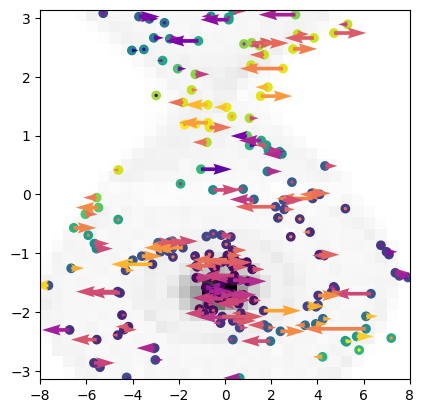

In [14]:
os.makedirs("plots/frames", exist_ok=True)
for frame in trange(vf_vals.shape[1]):
    plt.clf()
    plt.imshow(obs_heatmap, extent=[-8, 8, -np.pi, np.pi,], aspect=16.0 / (2 * np.pi), cmap='Greys')
    plt.scatter(ang_vel[:, frame], theta[:, frame], c=vf_vals[:, frame])
    plt.quiver(ang_vel[:, frame], theta[:, frame],
               all_actions[0, :, frame], 0, advantages[:, frame], width=0.01, cmap='plasma')
    plt.savefig(f"plots/frames/pendulum_frame={frame}.png")

In [15]:
run(['ffmpeg', '-y', '-i', 'plots/frames/pendulum_frame=%d.png', 'plots/pendulum.webm'])

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (GCC)
  configuration: --disable-static --prefix=/nix/store/eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee-ffmpeg-6.0 --target_os=linux --arch=x86_64 --pkg-config=pkg-config --enable-gpl --enable-version3 --disable-nonfree --enable-shared --enable-pic --disable-small --enable-runtime-cpudetect --disable-gray --enable-swscale-alpha --enable-hardcoded-tables --enable-safe-bitstream-reader --enable-pthreads --disable-w32threads --disable-os2threads --enable-network --enable-pixelutils --datadir=/nix/store/psm9ma325195370k8b64xnwg1g23rq3f-ffmpeg-6.0-data/share/ffmpeg --enable-ffmpeg --disable-ffplay --enable-ffprobe --bindir=/nix/store/eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee-ffmpeg-6.0-bin/bin --enable-avcodec --enable-avdevice --enable-avfilter --enable-avformat --enable-avutil --enable-postproc --enable-swresample --enable-swscale --libdir=/nix/store/eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee-ffmpeg-6.0-lib/lib --incdir=/nix/store

CompletedProcess(args=['ffmpeg', '-y', '-i', 'plots/frames/pendulum_frame=%d.png', 'plots/pendulum.webm'], returncode=0)

In [16]:
all_actions = np.stack([ep_data.episode['actions']
                        for ep_data in data['_replay_buffer']]).transpose(2, 0, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

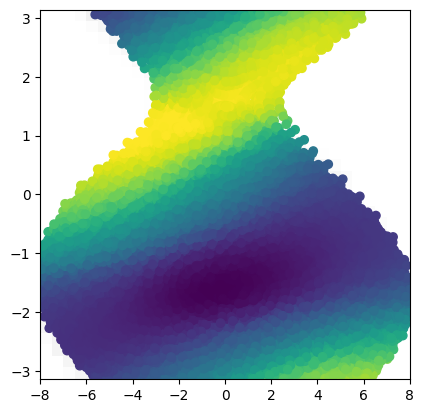

In [17]:
plt.clf()
plt.imshow(obs_heatmap, extent=[-8, 8, -np.pi, np.pi,], aspect=16.0 / (2 * np.pi), cmap='Greys')
for frame in trange(vf_vals.shape[1]):
    plt.scatter(ang_vel[:, frame], theta[:, frame], c=vf_vals[:, frame])
plt.savefig(f"plots/pendulum_vf.png")

  0%|          | 0/100 [00:00<?, ?it/s]

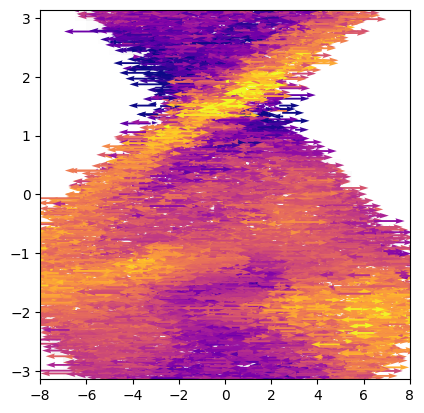

In [18]:
plt.clf()
plt.imshow(obs_heatmap, extent=[-8, 8, -np.pi, np.pi,], aspect=16.0 / (2 * np.pi), cmap='Greys')
for frame in trange(vf_vals.shape[1]):
    plt.quiver(ang_vel[:, frame], theta[:, frame],
               all_actions[0, :, frame], 0, advantages[:, frame], width=0.005, cmap='plasma')
plt.savefig(f"plots/pendulum_advantages.png")